In [1]:
!pip install pycocotools
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 9.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras


In [2]:
from pycocotools.coco import COCO
import os
import random
import cv2
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import segmentation_models as sm

2024-04-10 11:20:44.257783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 11:20:44.257883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 11:20:44.359712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
def getCOCO(anns_path):
    
    coco = COCO(anns_path)
    
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    nms = [cat['name'] for cat in cats]
    
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

def getMask(image_id, coco, classes, image_size):
    
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        
        binary = cv2.resize(coco.annToMask(ann), image_size, interpolation=cv2.INTER_AREA)

        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        mask[:, :, channel] = binary

        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

def getGenerator(path, coco, classes, image_size, batch_size, augment=False):
    
    c = 0
    n = os.listdir(path)
    random.shuffle(n)
    
    if augment == True:
        geo_aug = iaa.Fliplr(1.0)
    
    while (True):
        
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            
            img = cv2.imread(path + '/' + n[i])
            
            img =  cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            if augment == True:
                if random.random() < 0.5:
                    img = geo_aug(image=img)
                    mask = geo_aug(image=mask)            
            
            img_batch[i-c] = img
            mask_batch[i-c] = mask
        
        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch
        
def visualiseSamples(path, coco, classes, image_size, batch_size, augment=False):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size, augment)
    images, masks = next(temp_gen)
    
    for i in range(batch_size):
        plt.figure(figsize=(8, 16))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        
        true_mask = masks[i]
        for c in range(274):
            true_mask[:, :, c] = true_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(true_mask, axis=2))
        plt.axis('off')
        
        plt.show()
        
def showPredictions(generator, model):
    images, masks = next(generator)
    prediction = model.predict(images)
    
    for i in range(5):
        plt.figure(figsize=(10, 16))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        
        full_mask = masks[i]
        for c in range(274):
            full_mask[:, :, c] = full_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(full_mask, axis=2))
        plt.axis('off')
        
        pred_mask = np.round(prediction[i])
        for c in range(274):
            pred_mask[:, :, c] = pred_mask[:, :, c] * (c+1)
            
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.max(pred_mask, axis=2))
        plt.axis('off')
        
        plt.show()

In [20]:
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300

In [21]:
train_annotation_path = r'/kaggle/input/food-recognition/public_training_set_release_2.1/annotations.json'
train_image_path = r'/kaggle/input/food-recognition/public_training_set_release_2.1/images'
val_annotation_path = r'/kaggle/input/food-recognition/public_validation_set_release_2.1/annotations.json'
val_image_path = r'/kaggle/input/food-recognition/public_validation_set_release_2.1/images'

In [22]:
train_coco, train_classes = getCOCO(train_annotation_path)
val_coco, val_classes = getCOCO(val_annotation_path)

loading annotations into memory...
Done (t=5.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [23]:
train_gen = getGenerator(train_image_path, train_coco, train_classes, IMAGE_SIZE, BATCH_SIZE, True)
train_length = len(os.listdir(train_image_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_image_path, val_coco, val_classes, IMAGE_SIZE, BATCH_SIZE)
val_length = len(os.listdir(val_image_path))
print('Number of validation images: {}'.format(val_length))

Number of training images: 54392
Number of validation images: 948


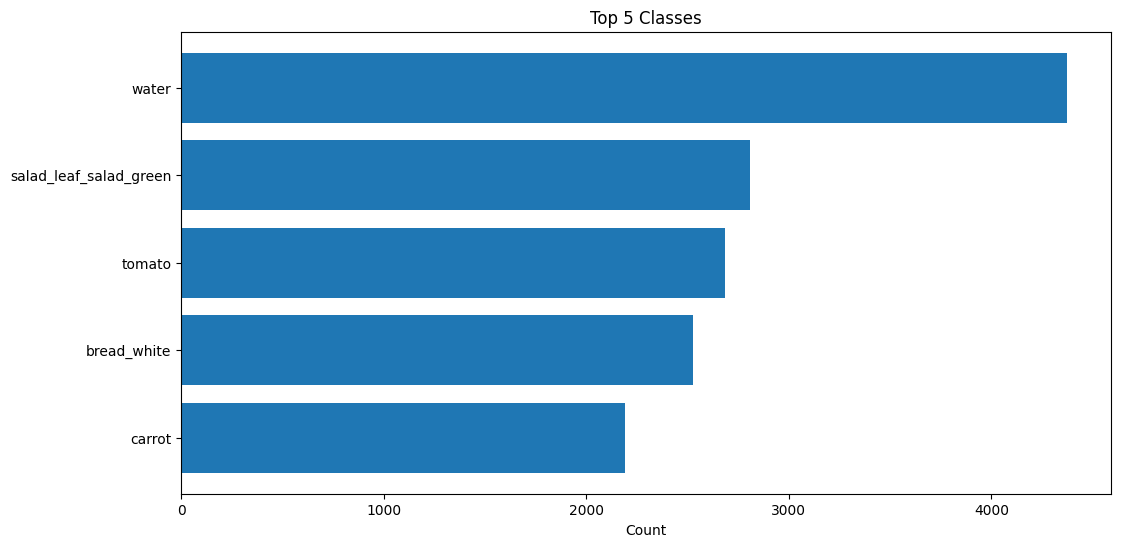

In [24]:
plt.figure(figsize=(12,6))

top_5 = train_classes.sort_values(by=['Count'], ascending=False)[:5]
top_5_keys = list(top_5.Category)
top_5_values = list(top_5.Count)

top_5_keys.reverse()
top_5_values.reverse()
plt.barh(top_5_keys, top_5_values)
plt.title('Top 5 Classes')
plt.xlabel('Count')

plt.show()

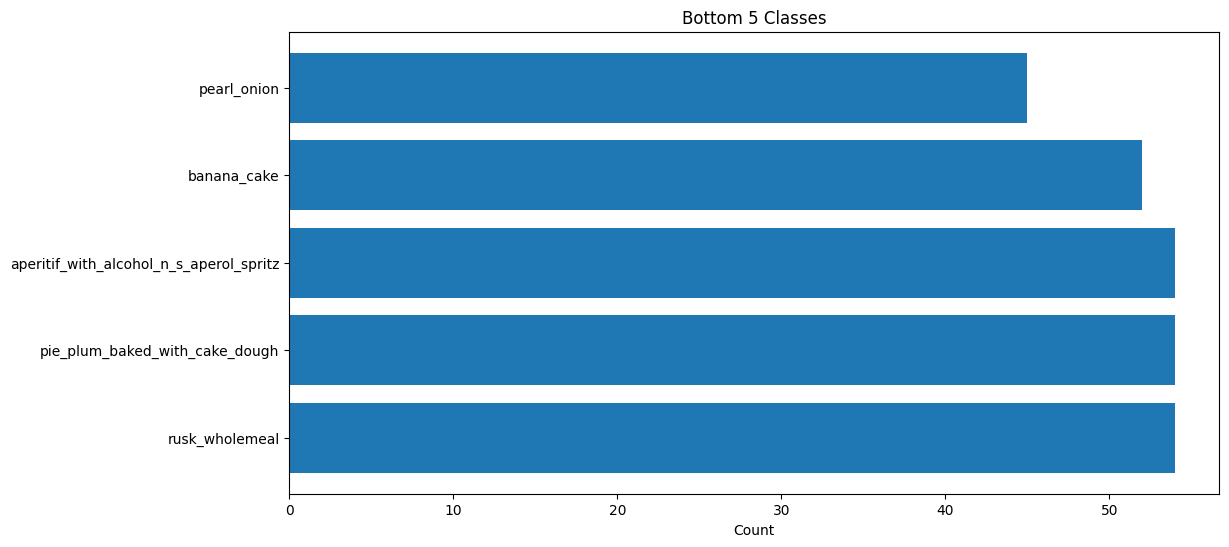

In [25]:
plt.figure(figsize=(12, 6))

bottom_5 = train_classes.sort_values(by=['Count'], ascending=True)[:5]
bottom_5_keys = list(bottom_5.Category)
bottom_5_values = list(bottom_5.Count)

bottom_5_keys.reverse()
bottom_5_values.reverse()
plt.barh(bottom_5_keys, bottom_5_values)
plt.title('Bottom 5 Classes')
plt.xlabel('Count')

plt.show()

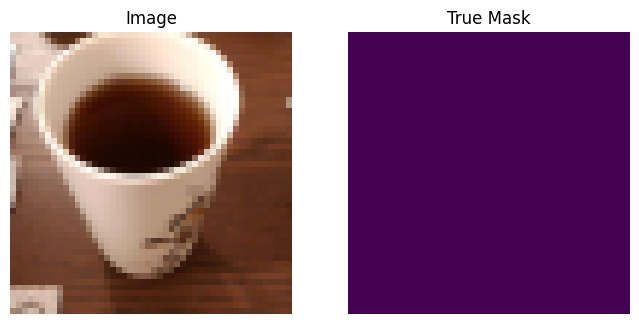

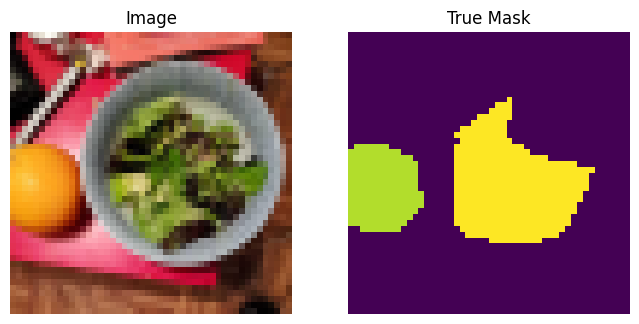

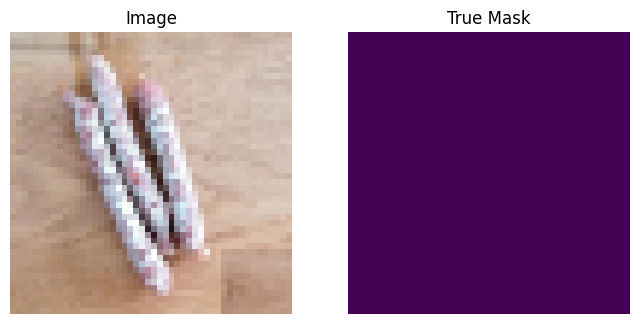

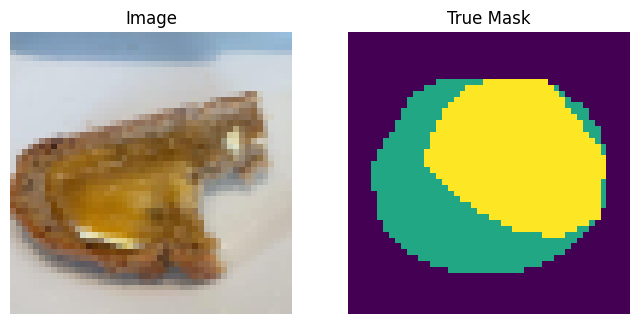

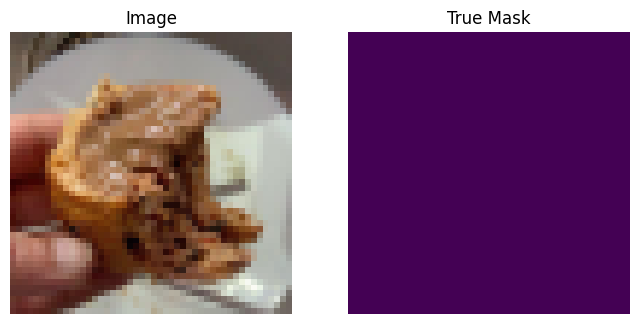

In [27]:
visualiseSamples(train_image_path, train_coco, train_classes, IMAGE_SIZE, 5, augment=True)

In [28]:
model = sm.PSPNet('efficientnetb7', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
def check_and_yield(generator):
    for x_batch, y_batch in generator:
        print("Batch shapes:", x_batch.shape, y_batch.shape)
        if x_batch.shape[2] > 274:  # Assuming axis 2 is the problematic one
            raise ValueError(f"Batch width exceeds expected size: {x_batch.shape[2]}")
        yield x_batch, y_batch

# Wrap your original generators with the check_and_yield function
train_gen_checked = check_and_yield(train_gen)
val_gen_checked = check_and_yield(val_gen)

In [36]:
try:
    x_batch, y_batch = next(train_gen)
    print("First batch from train_gen:", x_batch.shape, y_batch.shape)
except Exception as e:
    print("Error with train_gen:", str(e), type(e).__name__)
    import traceback
    traceback.print_exc()  # This prints the stack trace

try:
    x_batch, y_batch = next(val_gen)
    print("First batch from val_gen:", x_batch.shape, y_batch.shape)
except Exception as e:
    print("Error with val_gen:", str(e), type(e).__name__)
    import traceback
    traceback.print_exc()  # This prints the stack trace

Error with train_gen:  StopIteration
Error with val_gen:  StopIteration


Traceback (most recent call last):
  File "/tmp/ipykernel_34/3308444949.py", line 2, in <module>
    x_batch, y_batch = next(train_gen)
StopIteration
Traceback (most recent call last):
  File "/tmp/ipykernel_34/3308444949.py", line 10, in <module>
    x_batch, y_batch = next(val_gen)
StopIteration


In [31]:
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=10)

model.save_weights('weights.h5')

IndexError: list index out of range